# Estimating Baserates for HOT Content

This notebook uses the very large Jigsaw dataset to get base rate estimates of HOT content.

In [1]:
# Copyright 2025 Luke Moffett
# Licensed under the Apache License, Version 2.0

import datasets

In [ ]:
comments = datasets.load_dataset("civil_comments")
comments

In [3]:
all_records = datasets.concatenate_datasets([split for split in comments.values()])
all_records_df = all_records.to_pandas()
all_records_df

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
3,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.872340,0.021277,0.0
...,...,...,...,...,...,...,...,...
1999509,He should lose his job for promoting mis-infor...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1999510,"""Thinning project is meant to lower fire dange...",0.166667,0.000000,0.0,0.0,0.166667,0.166667,0.0
1999511,I hope you millennials are happy that you put ...,0.400000,0.000000,0.0,0.0,0.400000,0.100000,0.0
1999512,I'm thinking Kellyanne Conway (a.k.a. The Trum...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0


In [4]:
from nltk.tokenize import WhitespaceTokenizer
import tqdm

tokenizer = WhitespaceTokenizer()
matching_profile_records_df = all_records_df[(all_records_df['text'].str.len() < 2000)]

# need to count in a loop to avoid OOM
i = 0
exclusions = []
for idx, text in tqdm.tqdm(matching_profile_records_df[['text']].iterrows()):
    if len(tokenizer.tokenize(text['text'])) >= 8:
        i += 1
    else:
        exclusions.append(idx)

i, all_records_df.shape[0], i/all_records_df.shape[0]

1999514it [01:26, 23128.48it/s]


(1823222, 1999514, 0.9118325753158018)

In [5]:
match_df = matching_profile_records_df.drop(exclusions)
match_df

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
3,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.872340,0.021277,0.0
...,...,...,...,...,...,...,...,...
1999509,He should lose his job for promoting mis-infor...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1999510,"""Thinning project is meant to lower fire dange...",0.166667,0.000000,0.0,0.0,0.166667,0.166667,0.0
1999511,I hope you millennials are happy that you put ...,0.400000,0.000000,0.0,0.0,0.400000,0.100000,0.0
1999512,I'm thinking Kellyanne Conway (a.k.a. The Trum...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0


In [6]:
# Mappings are based off of
# - https://developers.perspectiveapi.com/s/about-the-api-attributes-and-languages?language=en_US
# - HotGPT Table 3
class_equvalencies = {
    'hateful': ['identity_attack', 'insult', 'severe_toxicity'],
    'offensive': ['obscene', 'sexual_explicit', 'insult', 'severe_toxicity'],
    'toxic': ['toxicity', 'severe_toxicity', 'threat']
}

for hot_class, hot_plus in class_equvalencies.items():
    for label in hot_plus:
        match_df[f'{label}_hard'] = match_df[label] > 0.5

    match_df[hot_class] = match_df.apply(lambda row: any(row[f'{label}_hard'] for label in hot_plus), axis=1)

match_df[['hateful', 'offensive', 'toxic']].describe()

,hateful,offensive,toxic
count,1823222,1823222,1823222
unique,2,2,2
top,False,False,False
freq,1736618,1736739,1714984


In [7]:
new_dist_df = match_df[['hateful', 'offensive', 'toxic']].value_counts().to_frame().rename(columns={0: 'count'}).reset_index()
new_dist_df

,hateful,offensive,toxic,count
0,False,False,False,1712047
1,True,True,True,79300
2,False,False,True,19233
3,True,False,True,4909
4,False,True,True,4796
5,True,True,False,1845
6,True,False,False,550
7,False,True,False,542


In [8]:
bootstrap_ratios = match_df[['hateful', 'offensive', 'toxic']].value_counts(normalize=True).to_frame().rename(columns={0: 'count'}).reset_index()

bootstrap_ratios

,hateful,offensive,toxic,count
0,False,False,False,0.939023
1,True,True,True,0.043494
2,False,False,True,0.010549
3,True,False,True,0.002692
4,False,True,True,0.002631
5,True,True,False,0.001012
6,True,False,False,0.000302
7,False,True,False,0.000297


In [9]:
# Uncomment to overwrite CSV
# bootstrap_ratios.to_csv('analysis/outputs/bootstrap_ratios.csv', index=False)

In [10]:
import pandas as pd

hot_distribution = {
    'hateful': [False, False, False, False, True, True, True, True],
    'offensive': [False, False, True, True, False, False, True, True],
    'toxic': [False, True, False, True, False, True, False, True],
    'count': [2381, 141, 196, 359, 57, 40, 44, 263]
}

hot_dist_df = pd.DataFrame(hot_distribution)
hot_dist_df

,hateful,offensive,toxic,count
0,False,False,False,2381
1,False,False,True,141
2,False,True,False,196
3,False,True,True,359
4,True,False,False,57
5,True,False,True,40
6,True,True,False,44
7,True,True,True,263


In [11]:
def hot_ratio(df):
    return df[df[['hateful', 'offensive', 'toxic']].apply(lambda hot: any(hot), axis=1)]['count'].sum()/df['count'].sum()

hot_ratio(hot_dist_df)

0.31600114909508764

In [12]:
hot_ratio(new_dist_df)

0.06097721506212628

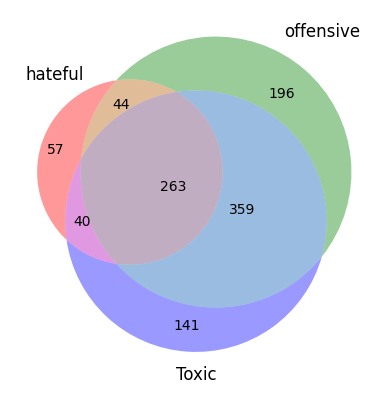

In [14]:
import pylab as plt
from matplotlib_venn import venn3, venn3_circles

def venn_hot(df):
    # Extracting subsets for the Venn diagram
    only_hateful = df[(df['hateful']) & ~(df['offensive']) & ~(df['toxic'])]['count'].sum()
    only_offensive = df[~(df['hateful']) & (df['offensive']) & ~(df['toxic'])]['count'].sum()
    only_toxic = df[~(df['hateful']) & ~(df['offensive']) & (df['toxic'])]['count'].sum()

    hateful_and_offensive = df[(df['hateful']) & (df['offensive']) & ~(df['toxic'])]['count'].sum()
    hateful_and_toxic = df[(df['hateful']) & ~(df['offensive']) & (df['toxic'])]['count'].sum()
    offensive_and_toxic = df[~(df['hateful']) & (df['offensive']) & (df['toxic'])]['count'].sum()

    all_three = df[(df['hateful']) & (df['offensive']) & (df['toxic'])]['count'].sum()

    # Plotting the Venn diagram
    venn3(subsets=(only_hateful, only_offensive, hateful_and_offensive, only_toxic, hateful_and_toxic, offensive_and_toxic, all_three),
        set_labels=('hateful', 'offensive', 'Toxic'))
    
venn_hot(hot_dist_df)

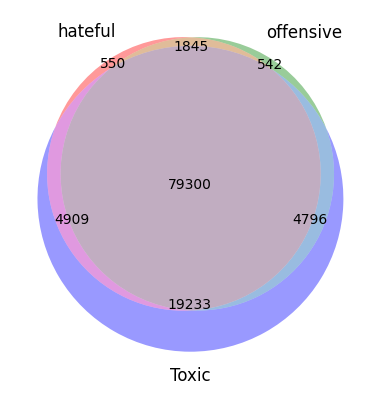

In [15]:
venn_hot(new_dist_df)